In [1]:
import lifelines
import pymc as pm
from pyBMA.CoxPHFitter import CoxPHFitter
import matplotlib.pyplot as plt
import numpy as np
from numpy import log
from datetime import datetime
import pandas as pd
%matplotlib inline  

The first step in any data analysis is acquiring and munging the data

Our starting data set can be found here:
   http://jakecoltman.com in the pyData post

It is designed to be roughly similar to the output from DCM's path to conversion

Download the file and transform it into something with the columns:

   id,lifetime,age,male,event,search,brand
   
where lifetime is the total time that we observed someone not convert for and event should be 1 if we see a conversion and 0 if we don't.  Note that all values should be converted into ints

It is useful to note that end_date = datetime.datetime(2016, 5, 3, 20, 36, 8, 92165)



In [2]:
running_id = 0
output = [[0]]
with open("E:/output.txt") as file_open:
    for row in file_open.read().split("\n"):
        cols = row.split(",")
        if cols[0] == output[-1][0]:
            output[-1].append(cols[1])
            output[-1].append(True)
        else:
            output.append(cols)
    output = output[1:]
    
for row in output:
    if len(row) == 6:
        row += [datetime(2016, 5, 3, 20, 36, 8, 92165), False]
output = output[1:-1]

In [3]:
def convert_to_days(dt):
    day_diff = dt / np.timedelta64(1, 'D')
    if day_diff == 0:
        return 23.0
    else: 
        return day_diff

df = pd.DataFrame(output, columns=["id", "advert_time", "male","age","search","brand","conversion_time","event"])
df["lifetime"] = pd.to_datetime(df["conversion_time"]) - pd.to_datetime(df["advert_time"])
df["lifetime"] = df["lifetime"].apply(convert_to_days)
df["male"] = df["male"].astype(int)
df["search"] = df["search"].astype(int)
df["brand"] = df["brand"].astype(int)
df["age"] = df["age"].astype(int)
df["event"] = df["event"].astype(int)
df = df.drop('advert_time', 1)
df = df.drop('conversion_time', 1)
df = df.set_index("id")
df = df.dropna(thresh=2)
df.median()

male         0.000000
age         38.000000
search       1.000000
brand        0.000000
event        1.000000
lifetime    15.951596
dtype: float64

In [ ]:
###Parametric Bayes
#Shout out to Cam Davidson-Pilon

In [3]:
## Example fully worked model using toy data
## Adapted from http://blog.yhat.com/posts/estimating-user-lifetimes-with-pymc.html
## Note that we've made some corrections 

N = 2500

##Generate some random data 
lifetime = pm.rweibull( 2, 5, size = N )
birth = pm.runiform(0, 10, N)
censor = ((birth + lifetime) >= 10)
lifetime_ = lifetime.copy()
lifetime_[censor] = 10 - birth[censor]


alpha = pm.Uniform('alpha', 0, 20)
beta = pm.Uniform('beta', 0, 20)

@pm.observed
def survival(value=lifetime_, alpha = alpha, beta = beta ):
    return sum( (1-censor)*(log( alpha/beta) + (alpha-1)*log(value/beta)) - (value/beta)**(alpha))

mcmc = pm.MCMC([alpha, beta, survival ] )
mcmc.sample(50000, 30000)

 [-----------      29%                  ] 14864 of 50000 complete in 21.5 secHalting at iteration  14874  of  50000


In [ ]:
pm.Matplot.plot(mcmc)
mcmc.trace("alpha")[:]

Problems: 

    1 - Try to fit your data from section 1 
    2 - Use the results to plot the distribution of the median
    
Note that the media of a Weibull distribution is:
$$β(log 2)^{1/α}$$    

In [8]:
censor = np.array(df["event"].apply(lambda x: 0 if x else 1).tolist())
alpha = pm.Uniform("alpha", 0,50) 
beta = pm.Uniform("beta", 0,50) 

@pm.observed
def survival(value=df["lifetime"], alpha = alpha, beta = beta ):
    return sum( (1-censor)*(np.log( alpha/beta) + (alpha-1)*np.log(value/beta)) - (value/beta)**(alpha))


mcmc = pm.MCMC([alpha, beta, survival ] )
mcmc.sample(10000)

 [-----------------100%-----------------] 10000 of 10000 complete in 16.9 sec

(array([  2.,   9.,  34.,  50.,  67.,  42.,  26.,  15.,   4.,   1.]),
 array([ 14.87534949,  14.88775119,  14.9001529 ,  14.9125546 ,
         14.9249563 ,  14.937358  ,  14.94975971,  14.96216141,
         14.97456311,  14.98696482,  14.99936652]),
 <a list of 10 Patch objects>)

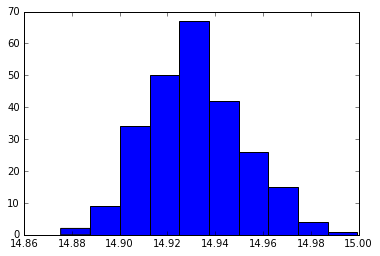

In [9]:
def weibull_median(alpha, beta):
    return beta * ((log(2)) ** ( 1 / alpha))
plt.hist([weibull_median(x[0], x[1]) for x in zip(mcmc.trace("alpha"), mcmc.trace("beta"))])

Problems:
    
    4 - Try adjusting the number of samples for burning and thinnning
    5 - Try adjusting the prior and see how it affects the estimate    

 [-----------------100%-----------------] 10000 of 10000 complete in 15.9 secPlotting beta
Plotting alpha


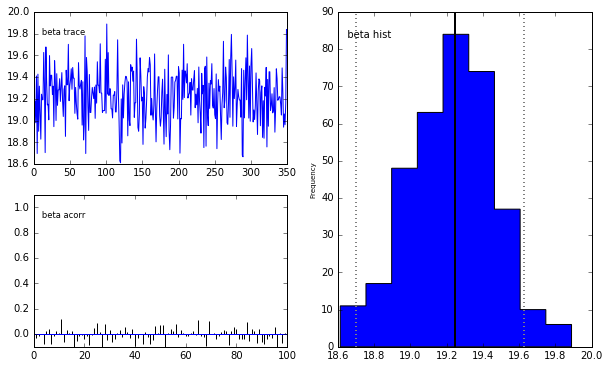

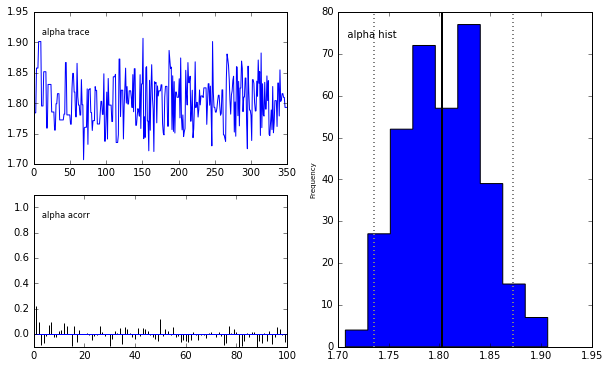

In [4]:
censor = np.array(df["event"].apply(lambda x: 0 if x else 1).tolist())
alpha = pm.Uniform("alpha", 0,50) 
beta = pm.Uniform("beta", 0,50) 

@pm.observed
def survival(value=df["lifetime"], alpha = alpha, beta = beta ):
    return sum( (1-censor)*(np.log( alpha/beta) + (alpha-1)*np.log(value/beta)) - (value/beta)**(alpha))

mcmc = pm.MCMC([alpha, beta, survival ] )
mcmc.sample(10000, burn = 3000, thin = 20)

pm.Matplot.plot(mcmc)

 [-----------------100%-----------------] 10000 of 10000 complete in 18.4 secPlotting beta
Plotting alpha


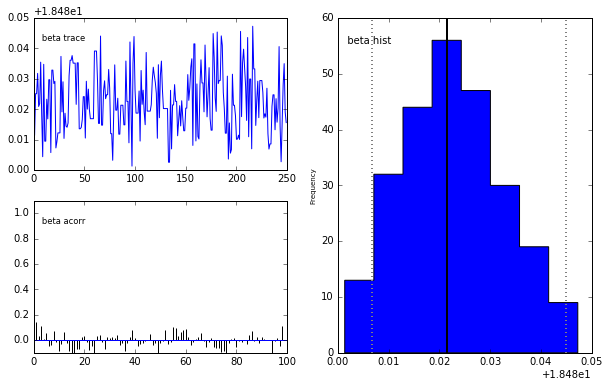

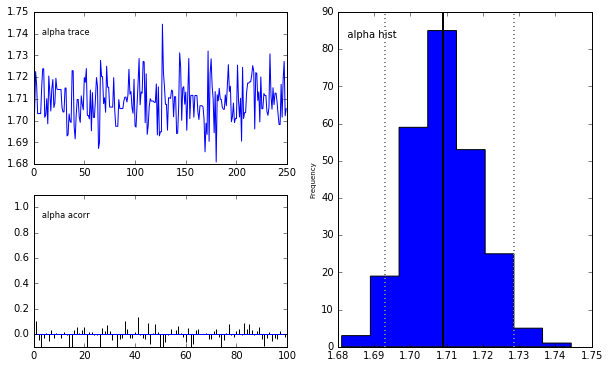

In [6]:
#Solution to Q5
## Adjusting the priors impacts the overall result
## If we give a looser, less informative prior then we end up with a broader, shorter distribution
## If we give much more informative priors, then we get a tighter, taller distribution

censor = np.array(df["event"].apply(lambda x: 0 if x else 1).tolist())

## Note the narrowing of the prior
alpha = pm.Normal("alpha", 1.7, 10000) 
beta = pm.Normal("beta", 18.5, 10000) 

####Uncomment this to see the result of looser priors
## Note this ends up pretty much the same as we're already very loose
#alpha = pm.Uniform("alpha", 0, 30) 
#beta = pm.Uniform("beta", 0, 30) 

@pm.observed
def survival(value=df["lifetime"], alpha = alpha, beta = beta ):
    return sum( (1-censor)*(np.log( alpha/beta) + (alpha-1)*np.log(value/beta)) - (value/beta)**(alpha))

mcmc = pm.MCMC([alpha, beta, survival ] )
mcmc.sample(10000, burn = 5000, thin = 20)
pm.Matplot.plot(mcmc)
#plt.hist([weibull_median(x[0], x[1]) for x in zip(mcmc.trace("alpha"), mcmc.trace("beta"))])

Problems:
    
    7 - Try testing whether the median is greater than a different values

In [15]:
medians = [weibull_median(x[0], x[1]) for x in zip(mcmc.trace("alpha"), mcmc.trace("beta"))]
testing_value = 14.9
number_of_greater_samples = sum([x >= testing_value for x in medians])
100 * (number_of_greater_samples / len(medians))

95.599999999999994

If we want to look at covariates, we need a new approach.  

We'll use Cox proprtional hazards, a very popular regression model.

To fit in python we use the module lifelines:

http://lifelines.readthedocs.io/en/latest/

In [6]:
#Fitting solution
cf = lifelines.CoxPHFitter()
cf.fit(df, 'lifetime', event_col = 'event')
cf.summary

C:\Users\j.coltman\AppData\Local\Continuum\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:285: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(duration_col, inplace=True)


,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
male,0.918199,2.504776,0.023830,38.531786,0.000000,0.871484,0.964915
age,-0.007011,0.993013,0.022145,-0.316614,0.751537,-0.050425,0.036402
search,-1.051111,0.349549,0.024398,-43.082327,0.000000,-1.098940,-1.003281
brand,0.011492,1.011558,0.022047,0.521233,0.602204,-0.031730,0.054713


Once we've fit the data, we need to do something useful with it.  Try to do the following things:

    1 - Plot the baseline survival function

    2 - Predict the functions for a particular set of features

    3 - Plot the survival function for two different set of features

    4 - For your results in part 3 caculate how much more likely a death event is for one than the other for a given period of time

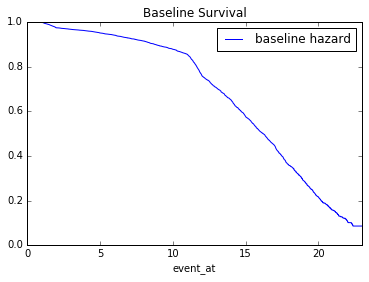

In [7]:
#Solution to 1
fig, axis = plt.subplots(nrows=1, ncols=1)
cf.baseline_survival_.plot(ax = axis, title = "Baseline Survival")

In [8]:
regressors = np.array([[1,45,0,0]])
survival = cf.predict_survival_function(regressors)
survival.head()

,0
event_at,
0.000000,1.000000
1.007159,0.998603
1.011755,0.997206
1.026149,0.995809
1.032037,0.994412


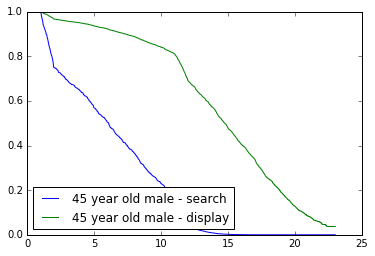

In [9]:
#Solution to plotting multiple regressors
fig, axis = plt.subplots(nrows=1, ncols=1, sharex=True)
regressor1 = np.array([[1,45,0,1]])
regressor2 = np.array([[1,23,1,1]])
survival_1 = cf.predict_survival_function(regressor1)
survival_2 = cf.predict_survival_function(regressor2)
plt.plot(survival_1,label = "45 year old male - search")
plt.plot(survival_2,label = "45 year old male - display")
plt.legend(loc = "upper")

In [ ]:
odds = survival_1 / survival_2
plt.plot(odds, c = "red")

Model selection

Difficult to do with classic tools (here)

Problem:

    1 - Calculate the BMA coefficient values
    
    2 - Try running with different priors

In [6]:
from pyBMA import CoxPHFitter
bmaCox = CoxPHFitter.CoxPHFitter()
bmaCox.fit(df, "lifetime", event_col= "event", priors= [0.5]*4)
bmaCox.summary

C:\Users\j.coltman\AppData\Local\Continuum\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:285: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(duration_col, inplace=True)


,coef,exp(coef)
age,-0.000122,0.999878
brand,0.000225,1.000225
male,0.917887,2.503993
search,-1.050679,0.349700


In [ ]:
#Low probability for everything favours parsimonious models
bmaCox = CoxPHFitter.CoxPHFitter()
bmaCox.fit(df, "lifetime", event_col= "event", priors= [0.1]*4)
bmaCox.summary

In [8]:
#Boost probability of brand
bmaCox = CoxPHFitter.CoxPHFitter()
bmaCox.fit(df, "lifetime", event_col= "event", priors= [0.3, 0.9, 0.001, 0.3])
print(bmaCox.summary)

            coef  exp(coef)
age    -0.000967   0.999033
brand   0.000085   1.000085
male    0.917849   2.503900
search -1.050716   0.349687


C:\Users\j.coltman\AppData\Local\Continuum\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:285: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(duration_col, inplace=True)
